# Visual Document NER v2

In [1]:
secret = ""
license = ""
version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.11/"

import os
os.environ['JSL_OCR_LICENSE'] = license

In [3]:
#%pip install spark-ocr==$version+spark30 --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade

In [4]:
#%pip install ../../python/dist/spark-ocr-3.9.0+spark30.tar.gz

In [5]:
import pyspark
import sparkocr
import json
import os

from pyspark.sql import SparkSession
from pyspark.ml import PipelineModel
import pyspark.sql.functions as f

from sparkocr.transformers import *
from sparkocr.utils import display_images
from sparkocr.enums import *

### Initialize Spark session

In [6]:
from sparkocr import start
from pyspark import SparkConf

spark = start(jar_path = spark_ocr_jar_path)
spark

Spark version: 3.0.2
Spark NLP version: 3.3.4
Spark OCR version: 3.9.1



## Load test images

In [7]:
import pkg_resources
test_image_path = pkg_resources.resource_filename('sparkocr', 'resources/ocr/forms/form1.jpg')
bin_df = spark.read.format("binaryFile").load(test_image_path)
bin_df.show()

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|file:/home/alexan...|2021-11-14 18:35:03|421333|[FF D8 FF E0 00 1...|
+--------------------+-------------------+------+--------------------+



## Display images


    Image #0:
    Origin: file:/home/alexander_jsl/Workspace/spark-ocr/python/sparkocr/resources/ocr/forms/form1.jpg
    Resolution: 150 dpi
    Width: 1240 px
    Height: 1755 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


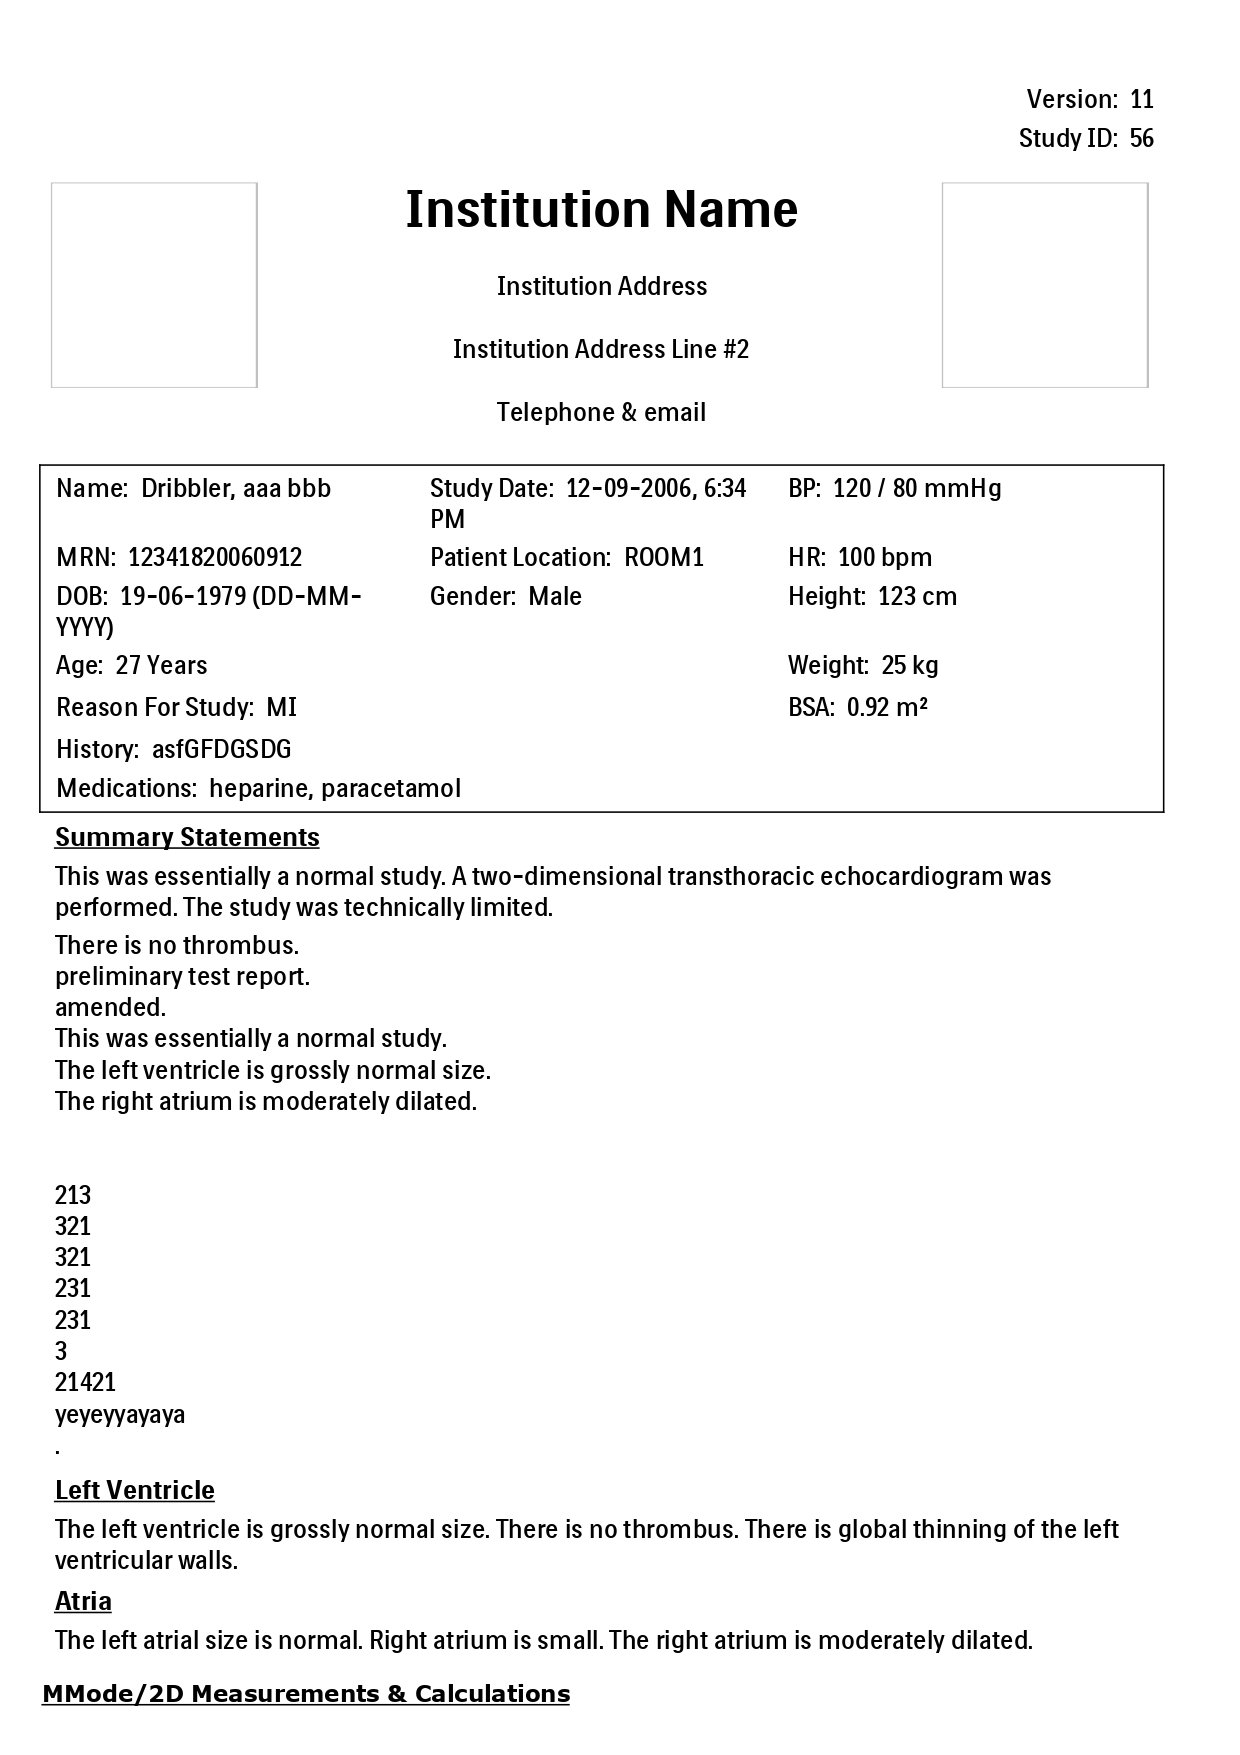

In [8]:
image_df = BinaryToImage().transform(bin_df)
display_images(image_df)

### Define pipeline

In [15]:
binary_to_image = BinaryToImage()\
    .setOutputCol("image") \
    .setImageType(ImageType.TYPE_3BYTE_BGR)

img_to_hocr = ImageToHocr()\
    .setInputCol("image")\
    .setOutputCol("hocr")\
    .setIgnoreResolution(False)\
    .setOcrParams(["preserve_interword_spaces=0"])

vocab_file = open(pkg_resources.resource_filename('sparkocr', "resources/models/layoutlm/LayoutLM.v2.voc.txt"), "r")
vocab = []
for line in vocab_file:
    vocab.append(line.strip())
vocab_file.close()
doc_ner = VisualDocumentNerV2()\
    .loadONNXModel(pkg_resources.resource_filename('sparkocr', "resources/models/layoutlm/LayoutLM.v2.onnx"), spark)\
    .setInputCols(["hocr", "image"])\
    .setOutputCol("entities")
doc_ner.setVocabulary(vocab)

draw = ImageDrawAnnotations() \
    .setInputCol("image") \
    .setInputChunksCol("entities") \
    .setOutputCol("image_with_annotations") \
    .setFontSize(10) \
    .setLineWidth(4)\
    .setRectColor(Color.red)

# OCR pipeline
pipeline = PipelineModel(stages=[
    binary_to_image,
    img_to_hocr,
    doc_ner,
    draw
])

## Call pipeline

In [16]:
results = pipeline.transform(bin_df).cache()

## Show results

In [17]:
## since pyspark2.3 doesn't have element_at, 'getItem' is involked
path_array = f.split(results['path'], '/')

# from pyspark2.4
# results.withColumn("filename", f.element_at(f.split("path", "/"), -1)) \

results.withColumn('filename', path_array.getItem(f.size(path_array)- 1)) \
    .withColumn("exploded_entities", f.explode("entities")) \
    .select("filename", "exploded_entities") \
    .show(truncate=False)
            

+---------+-----------------------------------------------------------------------------------------------------------------------------+
|filename |exploded_entities                                                                                                            |
+---------+-----------------------------------------------------------------------------------------------------------------------------+
|form1.jpg|[entity, 25, 35, b-header, [x -> 407, y -> 190, height -> 37, token -> institution, word -> Institution, width -> 241], []]  |
|form1.jpg|[entity, 37, 40, i-header, [x -> 667, y -> 190, height -> 37, token -> name, word -> Name, width -> 130], []]                |
|form1.jpg|[entity, 42, 52, b-question, [x -> 498, y -> 276, height -> 19, token -> institution, word -> Institution, width -> 113], []]|
|form1.jpg|[entity, 54, 60, i-question, [x -> 618, y -> 276, height -> 19, token -> address, word -> Address, width -> 89], []]         |
|form1.jpg|[entity, 62, 72, b-ques


    Image #0:
    Origin: file:/home/alexander_jsl/Workspace/spark-ocr/python/sparkocr/resources/ocr/forms/form1.jpg
    Resolution: 0 dpi
    Width: 1240 px
    Height: 1755 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


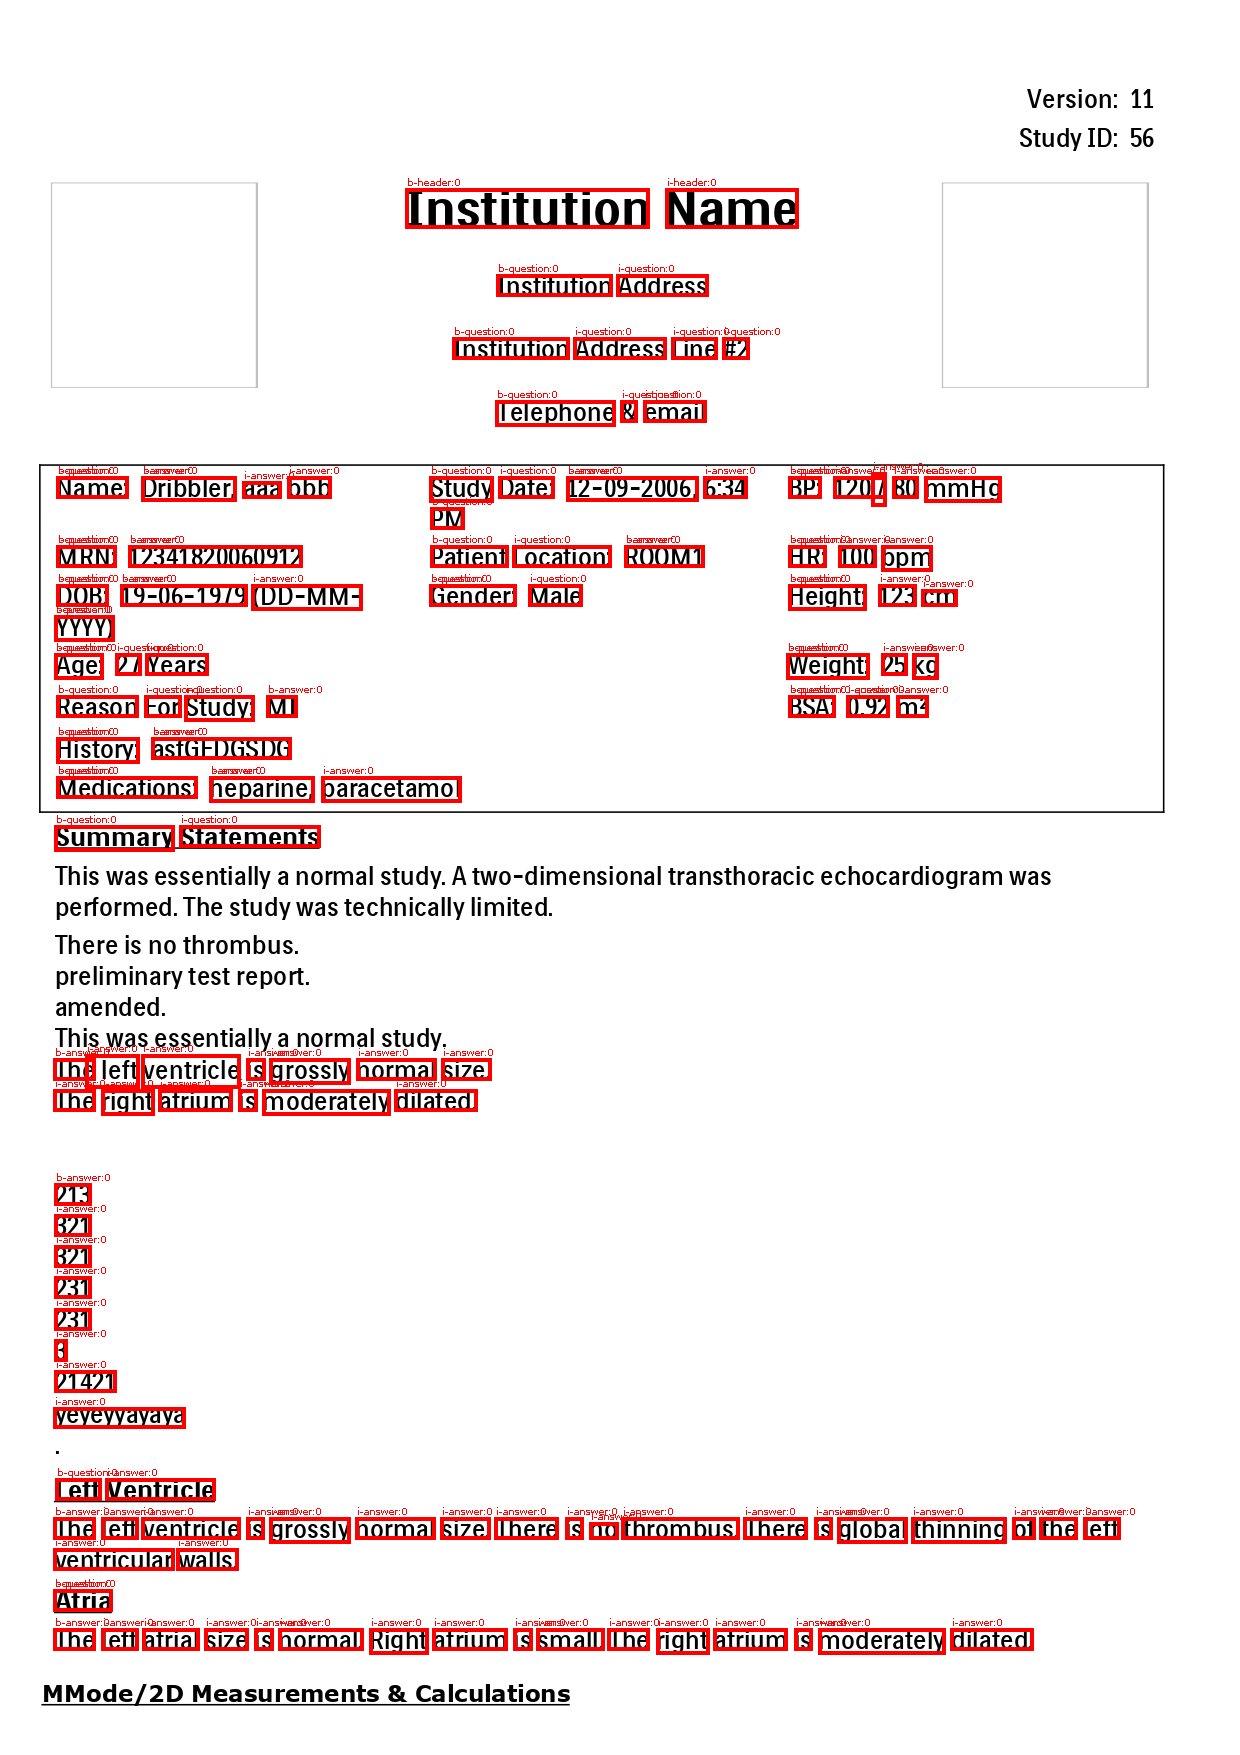

In [18]:
display_images(results, "image_with_annotations", width=1000)